Logs   
- [2023/03/08]   
  Restart this notebook if you change the scratch library

- [2024/03/22]   
  You do not need to restart this notebook when you change the scratch library


In [1]:
import requests
import csv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tqdm              # pip install tqdm
import seaborn as sns    # pip install seaborn
import plotly.graph_objects as go   # pip install plotly nbformat (and restart kernel)

# pip install -U scikit-learn
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

from typing import List, NamedTuple, Dict, Tuple
from collections import Counter, defaultdict

from scratch.linear_algebra import LinearAlgebra as la
from scratch.linear_algebra import Vector
from scratch.machine_learning import MachineLearning as ml

In [2]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
  'font.size': 16,
  'grid.alpha': 0.25})

In [3]:
%load_ext autoreload
%autoreload 2 

The idea of k-nearest neighbors is to predict a specific label in a point given 
labels of the surrounding points.

For example, when we want to predict what vote will take by a person, we can look 
what his/her neighbors are planning to vote.

## The Model

k-nearest neighbours will not help us to understand the driver of a phenomena
which influents the data. Another model will help, but not k-nearest neighbours

Let's say we've picked a number $k$ like 3 or 5. Then, when we want to classify some new
data point, we find the $k$ nearest labeled points and let them vote on the new output

In [9]:
def raw_majority_vote(labels: List[str]) -> str:
  votes = Counter(labels)
  # print(votes.most_common(2))
  winner, _ = votes.most_common(1)[0]
  return winner

In [10]:
raw_majority_vote(['a', 'b', 'c', 'b'])

'b'

If we have a tie, the above method would not resolve it.   
There are possible options to resolve the tie:
- Pick one of the winners at random.
- Weight the votes by distance and pick the weighted winner.
- Reduce $k$ until we find a unique winner.


Let's implement $k$-nearest neighbours according to the last option

In [7]:
def majority_vote(labels: List[str]) -> str:
  """Assumes that labels are ordered from nearest to farthest.
     The first index position is the origin and the last index
     position is the farthest position"""
  vote_counts = Counter(labels)
  winner, winner_count = vote_counts.most_common(1)[0]
  num_winners = len([count for count in vote_counts.values()
                      if count == winner_count])
  
  if num_winners == 1:
    return winner                       # unique winner, so return it
  else:
    return majority_vote(labels[:-1])   # try again without the farthest


# Tie, so look at first 4, then 'b'
majority_vote(['a', 'b', 'c', 'b', 'a'])

'b'

Improve the above function using `LabeledPoint` class.

In [8]:
class LabeledPoint(NamedTuple):
  point: Vector
  label: str


def knn_classify(k: int, labeled_points: List[LabeledPoint], new_point: Vector) -> str:
  # Order the labeled points from nearest to farthest
  by_distance = sorted(labeled_points, 
                       key=lambda lp: la.distance(lp.point, new_point))
  
  # Find the labels for the k closest
  k_nearest_labels = [lp.label for lp in by_distance[:k]]

  # and let them vote.
  return majority_vote(k_nearest_labels)

## Example: The Iris Dataset

The following data information can be found in this link: https://archive.ics.uci.edu/dataset/53/iris  

A good paper that traced back the source of Iris dataset:
[(Unwin and Kleinman, 2021) - The Iris Data Set: In Search of the Source of _Virginica_](https://academic.oup.com/jrssig/article/18/6/26/7038520)

Let us download the dataset from UC Irvine Machine Learning Repository

In [10]:
data = requests.get(
  "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data")

with open('./datasets/iris.data', 'w') as f:
  f.write(data.text)

<img src="./img-resources/knn-nb-iris-images.png" width=600>

In [11]:
# !cat "datasets/iris.data"     # mac/linux
!type "datasets\iris.data"     # windows

5.1,3.5,1.4,0.2,Iris-setosa
4.9,3.0,1.4,0.2,Iris-setosa
4.7,3.2,1.3,0.2,Iris-setosa
4.6,3.1,1.5,0.2,Iris-setosa
5.0,3.6,1.4,0.2,Iris-setosa
5.4,3.9,1.7,0.4,Iris-setosa
4.6,3.4,1.4,0.3,Iris-setosa
5.0,3.4,1.5,0.2,Iris-setosa
4.4,2.9,1.4,0.2,Iris-setosa
4.9,3.1,1.5,0.1,Iris-setosa
5.4,3.7,1.5,0.2,Iris-setosa
4.8,3.4,1.6,0.2,Iris-setosa
4.8,3.0,1.4,0.1,Iris-setosa
4.3,3.0,1.1,0.1,Iris-setosa
5.8,4.0,1.2,0.2,Iris-setosa
5.7,4.4,1.5,0.4,Iris-setosa
5.4,3.9,1.3,0.4,Iris-setosa
5.1,3.5,1.4,0.3,Iris-setosa
5.7,3.8,1.7,0.3,Iris-setosa
5.1,3.8,1.5,0.3,Iris-setosa
5.4,3.4,1.7,0.2,Iris-setosa
5.1,3.7,1.5,0.4,Iris-setosa
4.6,3.6,1.0,0.2,Iris-setosa
5.1,3.3,1.7,0.5,Iris-setosa
4.8,3.4,1.9,0.2,Iris-setosa
5.0,3.0,1.6,0.2,Iris-setosa
5.0,3.4,1.6,0.4,Iris-setosa
5.2,3.5,1.5,0.2,Iris-setosa
5.2,3.4,1.4,0.2,Iris-setosa
4.7,3.2,1.6,0.2,Iris-setosa
4.8,3.1,1.6,0.2,Iris-setosa
5.4,3.4,1.5,0.4,Iris-setosa
5.2,4.1,1.5,0.1,Iris-setosa
5.5,4.2,1.4,0.2,Iris-setosa
4.9,3.1,1.5,0.1,Iris-setosa
5.0,3.2,1.2,0.2,Iris


datasets\iris.data


The system cannot find the file specified.
Error occurred while processing: #.
The system cannot find the file specified.
Error occurred while processing: windows.


Each column represents consecutively sepal length (cm), sepal width (cm),   
petal length (cm), petal width (cm), and class

Representing our data using `LabeledPoint`

In [12]:
def parse_iris_row(row: List[str]) -> LabeledPoint:
  """sepal_length, sepal_width, petal_length, petal_width, class"""
  measurements = [float(value) for value in row[:-1]]

  # class is e.g. "Iris-virginica"; we just want "virginica"
  if len(row) != 0:
    label = row[-1].split("-")[-1]
    return LabeledPoint(measurements, label)
  else:
    return None


with open("./datasets/iris.data") as f:
  reader = csv.reader(f)
  iris_data = [parse_iris_row(row) for row in reader]

iris_data = [row for row in iris_data if row != None]

# We'll also group just the points by species/label so we can plot them
points_by_species: Dict[str, List[Vector]] = defaultdict(list)
for iris in iris_data:
  points_by_species[iris.label].append(iris.point)

In [13]:
iris_data[:5]

[LabeledPoint(point=[5.1, 3.5, 1.4, 0.2], label='setosa'),
 LabeledPoint(point=[4.9, 3.0, 1.4, 0.2], label='setosa'),
 LabeledPoint(point=[4.7, 3.2, 1.3, 0.2], label='setosa'),
 LabeledPoint(point=[4.6, 3.1, 1.5, 0.2], label='setosa'),
 LabeledPoint(point=[5.0, 3.6, 1.4, 0.2], label='setosa')]

In [14]:
points_by_species

defaultdict(list,
            {'setosa': [[5.1, 3.5, 1.4, 0.2],
              [4.9, 3.0, 1.4, 0.2],
              [4.7, 3.2, 1.3, 0.2],
              [4.6, 3.1, 1.5, 0.2],
              [5.0, 3.6, 1.4, 0.2],
              [5.4, 3.9, 1.7, 0.4],
              [4.6, 3.4, 1.4, 0.3],
              [5.0, 3.4, 1.5, 0.2],
              [4.4, 2.9, 1.4, 0.2],
              [4.9, 3.1, 1.5, 0.1],
              [5.4, 3.7, 1.5, 0.2],
              [4.8, 3.4, 1.6, 0.2],
              [4.8, 3.0, 1.4, 0.1],
              [4.3, 3.0, 1.1, 0.1],
              [5.8, 4.0, 1.2, 0.2],
              [5.7, 4.4, 1.5, 0.4],
              [5.4, 3.9, 1.3, 0.4],
              [5.1, 3.5, 1.4, 0.3],
              [5.7, 3.8, 1.7, 0.3],
              [5.1, 3.8, 1.5, 0.3],
              [5.4, 3.4, 1.7, 0.2],
              [5.1, 3.7, 1.5, 0.4],
              [4.6, 3.6, 1.0, 0.2],
              [5.1, 3.3, 1.7, 0.5],
              [4.8, 3.4, 1.9, 0.2],
              [5.0, 3.0, 1.6, 0.2],
              [5.0, 3.4, 1.6, 0.4],


In [15]:
all_labels = list(points_by_species.keys())
all_labels

['setosa', 'versicolor', 'virginica']

In [16]:
for label in all_labels:
  print(f"{label}: {len(points_by_species[label])}")

setosa: 50
versicolor: 50
virginica: 50


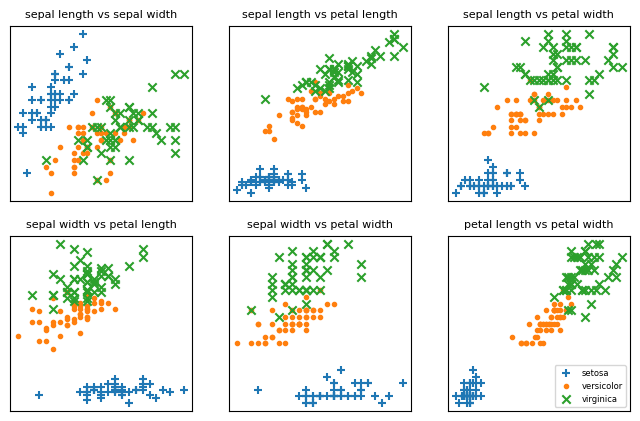

In [17]:
metrics = ['sepal length', 'sepal width', 'petal length', 'petal width']
pairs = [(i, j) for i in range(4) for j in range(4) if i < j]
marks = ['+', '.', 'x']     # we have 3 classes, so 3 markers

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(8, 5))

for row in range(2):
  for col in range(3):
    i, j = pairs[3 * row + col]

    ax[row][col].set_title(f"{metrics[i]} vs {metrics[j]}", fontsize=8)
    ax[row][col].set_xticks([])
    ax[row][col].set_yticks([])

    for mark, (species, points) in zip(marks, points_by_species.items()):
      xs = [point[i] for point in points]
      ys = [point[j] for point in points]

      ax[row][col].scatter(xs, ys, marker=mark, label=species)

ax[-1][-1].legend(loc="lower right", prop={'size': 6})
plt.show()

Split the data into a test and a training set

In [18]:
seed = 2023_04_19
rng = np.random.default_rng(seed)

iris_train, iris_test = ml.split_data(iris_data, 0.70, rng)

print(f"len(iris_train) = {len(iris_train)}")
print(f"len(iris_test) = {len(iris_test)}")

len(iris_train) = 105
len(iris_test) = 45


Predict with $k$-NN with $k=5$

To get the visualization of iris dataset, we use PCA. see `ch-10-working-with-data.ipynb`   
for the code how to produce the following image

<img src="./img-resources/knn-nb-knn-explained-with-pca.png" width=800>

In [19]:
y_true = []
y_pred = []
for iris in iris_test:
  y_pred.append(knn_classify(5, iris_train, iris.point))
  y_true.append(iris.label)

In [20]:
# track how many times we see (predicted, actual)
confusion_matrix: Dict[Tuple[str, str], int] = defaultdict(int)
num_correct = 0

for predicted, actual in zip(y_pred, y_true):
  if predicted == actual:
    num_correct += 1
  
  confusion_matrix[(predicted, actual)] += 1

pct_correct = num_correct / len(iris_test)
print(pct_correct)
print(confusion_matrix)

0.9555555555555556
defaultdict(<class 'int'>, {('versicolor', 'versicolor'): 16, ('virginica', 'virginica'): 15, ('setosa', 'setosa'): 12, ('virginica', 'versicolor'): 2})


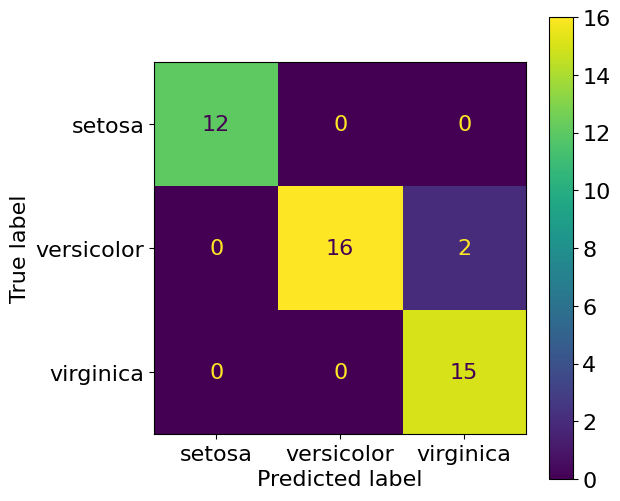

In [21]:
fig, ax = plt.subplots(figsize=[6, 6])
ConfusionMatrixDisplay.from_predictions(y_true, y_pred, ax=ax);
plt.show(fig)

In [22]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        12
  versicolor       1.00      0.89      0.94        18
   virginica       0.88      1.00      0.94        15

    accuracy                           0.96        45
   macro avg       0.96      0.96      0.96        45
weighted avg       0.96      0.96      0.96        45



## The Curse of Dimensionality

Generating random points and random distances from the interval $[0, 1]^N$.   
$N$ is the dimension of the generated points

In [23]:
def random_distances(dim: int, num_pairs: int, rng) \
    -> List[float]:

  return [la.distance(rng.random(dim), rng.random(dim)) for _ in range(num_pairs)]

For every dimension from 1 to 100, we'll compute 10_000 distance and uses those   
to compute the average distance between points and the minimum distance between   
points in each dimension

In [24]:
dimensions = range(1, 100)

avg_distances = []
min_distances = []

seed = 2023_03_19
rng = np.random.default_rng(seed)
for dim in tqdm.tqdm(dimensions, desc="Curse of dimensionality"):
  distances = random_distances(dim, 10_000, rng)    # 10,000 randomn pairs
  avg_distances.append(sum(distances) / 10_000)           # track the average
  min_distances.append(min(distances))                    # trach the minimum

Curse of dimensionality: 100%|██████████| 99/99 [00:14<00:00,  6.72it/s]


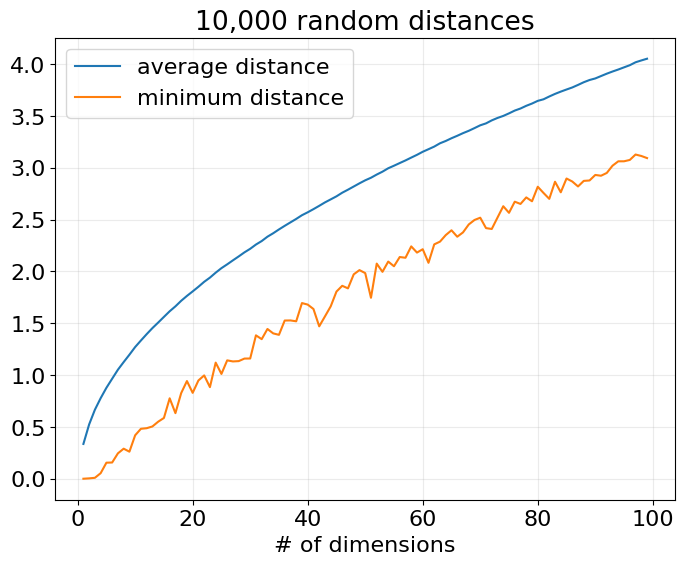

In [25]:
fig, ax = plt.subplots(figsize=(8, 6))

x_dims = list(dimensions)

ax.plot(x_dims, avg_distances, label="average distance")
ax.plot(x_dims, min_distances, label="minimum distance")

ax.set_xlabel("# of dimensions")
ax.set_title("10,000 random distances")

ax.grid('on')
ax.legend(loc="upper left")


plt.show(fig)

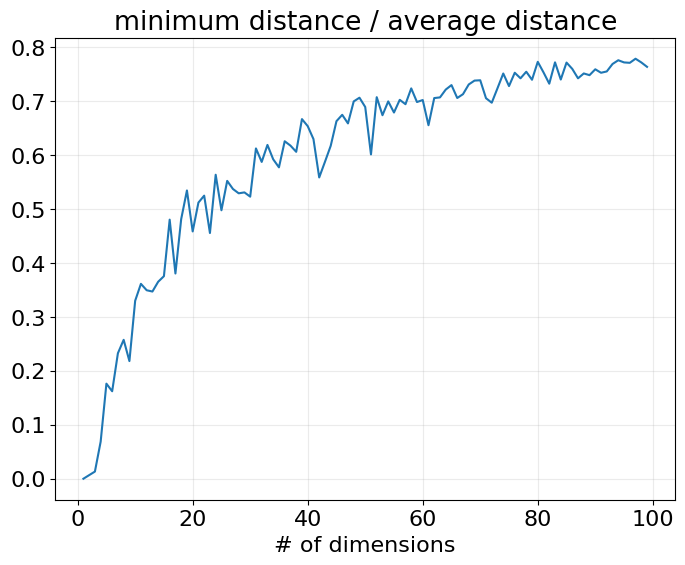

In [26]:
fig, ax = plt.subplots(figsize=(8, 6))

x_dims = list(dimensions)

y_ratio = [min_dist / avg_dist for min_dist, avg_dist 
            in zip(min_distances, avg_distances)]
ax.plot(x_dims, y_ratio)

ax.set_xlabel("# of dimensions")
ax.set_title("minimum distance / average distance")

ax.grid('on')


plt.show(fig)

In low-dimensional datasets, the closest points tend to be much closer
than the average. But two points are close only if they are close in
every dimension, and every extra dimension&mdash;even if just noise&mdash;
is another opportunity for each point to be farther away from every
other point. When you haev a lot of dimensions, it's likely that the
closest point aren't much closer than evarage, so two points
being close doesn't mean very much (unless there's a lot of structure
in your data that makes it behaves as if it were much lower-dimensional)

Another way of thinking, why the more dimension of data that you have, 
the more distance (more difficult to have good model) between two points is by looking
of sparsity (the density of points)

Fifty random points in one dimension. For the sake of visualization, we add
some shifts in the y-direction.   
We clearly see there is a pretty good coverage. All the area is covered by 
the random points.

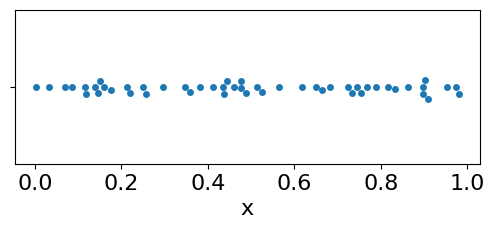

In [27]:
seed = 24_03_22
N = 50
rng = np.random.default_rng(seed)
fifty_rand = rng.random(N)

df_fifty = pd.DataFrame(fifty_rand, columns=["x"])

fig, ax = plt.subplots(figsize=(6, 2))

sns.swarmplot(df_fifty, x="x", ax=ax)

plt.show(fig)

Fifty random points in two dimensions

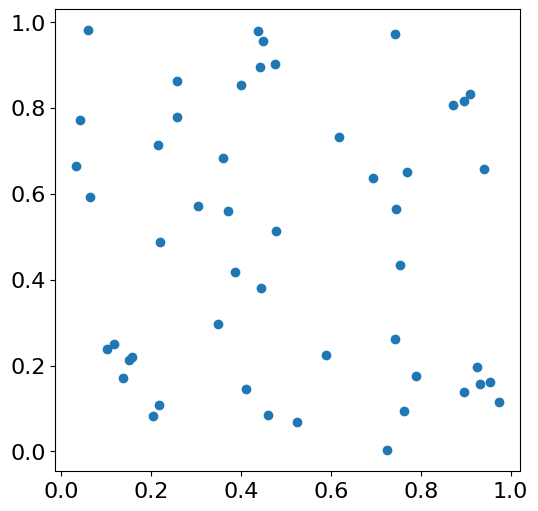

In [28]:
seed = 24_03_22
N = 50
rng = np.random.default_rng(seed)
fifty_rand_2d = rng.random(size=(N, 2))

fig, ax = plt.subplots(figsize=(6, 6))

ax.scatter(fifty_rand_2d[:, 0], fifty_rand_2d[:, 1])

plt.show(fig)

And in three dimensions

In [36]:
seed = 24_03_22
N = 50
rng = np.random.default_rng(seed)
fifty_rand_3d = rng.random(size=(N, 3))

fig = go.Figure(
  data=[
    go.Scatter3d(
      x=fifty_rand_3d[:, 0], y=fifty_rand_3d[:, 1], z=fifty_rand_3d[:, 2], 
      mode="markers", 
      marker={"color": fifty_rand_3d[:, 2], "size": 5, "colorscale": "Viridis", 
              "colorbar": {"thickness": 10, "len": 0.85, "x": 0.85}},
      name="data")])

r = 2
camera = {"eye": {"x": -0.5*r, "y": r, "z": 0.5*r},
          "center": dict(x=0, y=0, z=-0.2)}
fig.update_layout(autosize=False, width=500, height=400, 
                  scene={"xaxis_title": "x1",
                         "yaxis_title": "x2",
                         "zaxis_title": "x3", 
                         "xaxis": dict(autorange="reversed"),
                         "yaxis": dict(autorange="reversed")},
                  margin={"l":5, "r":10, "b":5, "t":10},
                  scene_camera=camera,
                  scene_aspectmode="cube",
                  legend={"x": 0.1, "y": 0.9})

fig.show()


In three dimensional space, we see that there are more empty spaces for
the same number of points compare to the one dimensional space.

So if you're trying to use nearest neighbors in higher dimensions, it's probably a good idea to do some kind of dimensionality reduction first.